# Metropolis Algorithm

In [1]:
import numpy as np
from scipy import stats
from math import sqrt, exp, log
from matplotlib import pyplot as plt

Function that accepts an integer $n$ and returns a random spin configuration for an $n \times n$ lattice (as an $n \times n$ NumPy array of $1$s and $-1$s).

In [2]:
def random_lattice(n):
    """Construct a random spin configuration for an nxn lattice."""
    return np.random.binomial(1,.5,(n,n))*2 - 1

Function tested with $n = 100$, plotting the spin configuration via `plt.imshow()`.

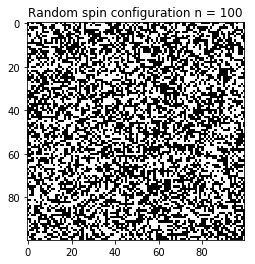

In [3]:
lattice = random_lattice(100)
plt.imshow(lattice, cmap='gray')
plt.title("Random spin configuration n = 100")
plt.show()

Function that accepts a spin configuration $\sigma$ for a lattice as a NumPy array.
Energy $H(\sigma)$ computed of the spin configuration.

In [4]:
def lattice_energy(L):
    """Computer the energy of the spin configuration corresponding to the
    lattice L.
    """
    vertical = L * (np.roll(L,1,axis=0) + np.roll(L,1,axis=1))
    return -np.sum(vertical)

In [5]:
energy = lattice_energy(lattice)
print(energy)

-92


Function that accepts an integer $n$ and chooses a pair of indices $(i,j)$ where $0 \le i,j \le n-1$.
Each possible pair has an equal probability $\frac{1}{n^2}$ of being chosen.

In [6]:
def flip_location(n):
    """Choose a random pair of indices 0 <= i,j <= n-1."""
    return (np.random.randint(0,n,2))

In [7]:
i,j = flip_location(50)
print(i,j)

24 21


Function that accepts a spin configuration $\sigma$, its energy $H(\sigma)$, and integer indices $i$ and $j$.
Computes the energy of the new spin configuration $\sigma^*$, which is $\sigma$ but with the spin flipped at the $(i,j)$th entry of the corresponding lattice.

In [16]:
def updated_energy(L, L_energy, i, j):
    """Compute the energy of the spin configuration that results
    when the (i,j)th spin of L is flipped.
    """
    n = np.shape(L)[0]
    flip = L[(i+1)%n,j] + L[i,(j+1)%n] + L[(i-1)%n,j] + L[i,(j-1)%n]
    
    # Don't flip yet, don't forget to multiply by L[i,j]
    return L_energy + 2*flip*L[i,j]

In [17]:
updated_energy(lattice, energy,i,j)

-92

Function that accepts a float $\beta$ and spin configuration energies $H(\sigma)$ and $H(\sigma^*)$.
Calculates whether or not the new spin configuration $\sigma^*$ should be accepted (return `True` or `False`).

In [13]:
def accept(beta, energy_old, energy_new):
    """Accept or reject the new spin configuration."""
    if energy_new < energy_old:
        return True
    else:
        prob = np.exp(beta*(energy_old - energy_new))
        return np.random.binomial(1,prob)

Function that accepts a float $\beta>0$ and integers $n$, `n_samples`, and `burn_in`.
Initialize an $n\times n$ lattice for a spin configuration $\sigma$ using `random_lattice()`.
Uses the Metropolis algorithm to (potentially) update the lattice `burn_in` times.
1. `flip_location()` chooses a site for possibly flipping the spin, thus defining a potential new configuration $\sigma^*$.
2. `updated_energy()` calculates the energy $H(\sigma^*)$ of the proposed configuration.
3. `accept()` accepts or rejects the proposed configuration. If it is accepted, sets $\sigma = \sigma^*$ by flipping the spin at the indicated site.
4. Tracks $-\beta H(\sigma)$ at each iteration (independent of acceptance).

After the burn-in period, continues the iteration `n_samples` times, also records every $100$th sample (to prevent memory failure).
Returns the samples, the sequence of weighted energies $-\beta H(\sigma)$, and the acceptance rate.

Tested on a $100 \times 100$ grid with $200000$ total iterations, with `n_samples` large enough to keep $50$ samples, for $\beta = 0.2, 0.4, 1$.
Plots the proportional log probabilities, as well as a late sample from each test.


In [14]:
def ising_metropolis(beta, n=100, n_samples=5000, burn_in=195000):
    """Use the Metropolis algorithm to choose new spin configurations.

    Parameters:
        beta (float > 0): Constant inversely proportional to the temperature.
        N (int > 0): The size of the lattice.
        n_samples (int): The number of samples to generate.
        burnin (int): The number of iterations to burn before sampling.

    Returns:
        ((n_samples//100, n,n) ndarray): The sampled spin configurations.
        (n_samples) ndarray: The weighted energies of each configuration.
        (float): The proportion of proposed samples that were accepted.
    """
    betaH = []
    samples = []
    count_accept = 0
    total = n_samples + burn_in
    lattice = random_lattice(n)
    energy = lattice_energy(lattice)
    
    for k in range(total):
        i,j = flip_location(n)
        new_energy = updated_energy(lattice,energy,i,j)
        
        # if accept, flip the i,j entry and update energy
        if accept(beta, energy, new_energy):
            lattice[i,j] *= -1
            energy = new_energy
            # Only count acceptance after burn in or the rate will be close to 1
            if k > burn_in:
                count_accept += 1
            
        # for n_samples append every 100 samples
        if k > burn_in:
            r = k - burn_in
            if (r % 100) == 0:
                samples.append(lattice)
                
        betaH.append(-beta*energy)
    return betaH, samples, count_accept/n_samples

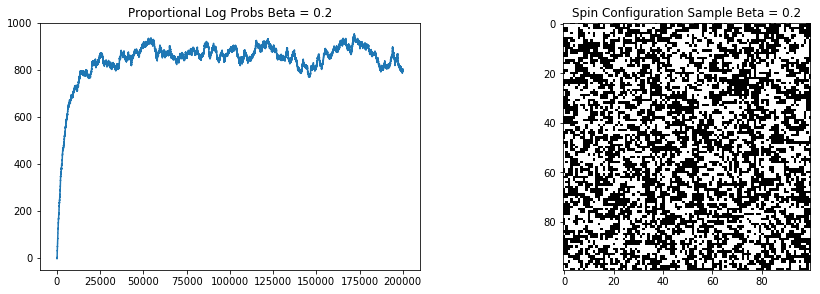

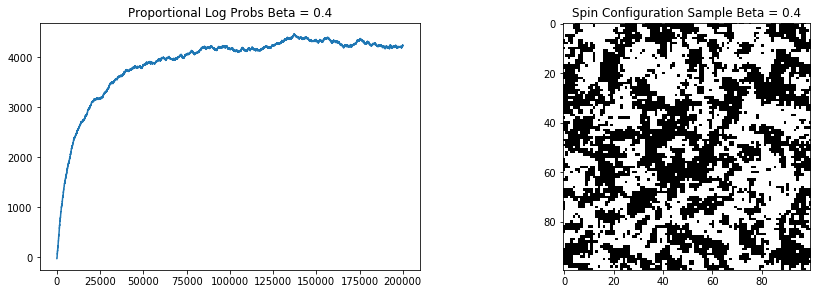

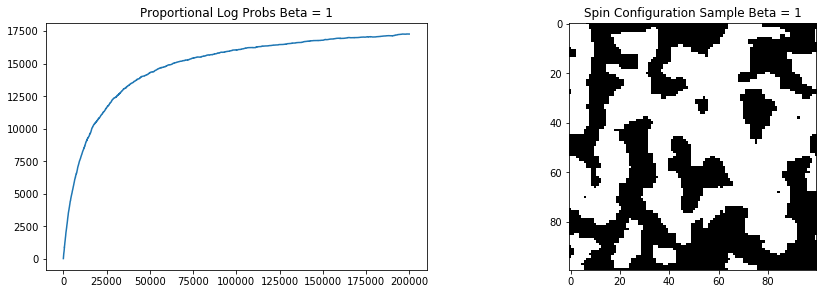

In [19]:
betas = [.2,.4,1]
for beta in betas:
    betaH, samples, accept_rate = ising_metropolis(beta, n=100)
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.plot(betaH)
    plt.title("Proportional Log Probs Beta = {}".format(beta))
    plt.subplot(2,2,2)
    plt.imshow(samples[-1],cmap='gray')
    plt.title("Spin Configuration Sample Beta = {}".format(beta))
    plt.show()